# 重要性采样

# Monte Carlo Method 
重要性采样是脱胎于蒙特卡罗方法的一个技巧，我们先了解什么是蒙特卡罗方法。  
* 核心思想：通过从概率分布中随机采样并计算样本的均值，来近似难以直接计算的积分（或期望值）。
* 数学原理：基于大数定律，它是一种基于“随机抽样”的数值计算方法论。

$$\mathbb{E}_{x \thicksim p} = \int f(x)p(x) \approx \frac{1}{N} \sum_{N}^{i} f(x_i), \hspace{0.5em}
x_i \thicksim p(x) $$
- $x \thicksim p(x) i.i.d.$ 独立同分布，这样就能用样本均值逼近期望。
- 优点：无偏、一致估计

In [1]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
true_value = 2.0
torch.manual_seed(0)

In [3]:
# --- 方法 1: 标准蒙特卡罗 (从 p 直接采样) ---
N = 10000  # 样本数
p = dist.Normal(1.0, 1.0)  # 目标分布 p: N(1, 1)
samples_p = p.sample((N,))  # 从 p 采样
f_x = samples_p.pow(2)  # 计算 f(x) = x^2 -> E(x**2) = D(x) + E(x)
mc_estimate = f_x.mean()
mc_std = f_x.std() / torch.sqrt(torch.tensor(N))

print(f"标准蒙特卡罗估计: {mc_estimate:.4f} ± {mc_std:.4f}")
print(f"与真实值的误差: {abs(mc_estimate - true_value):.4f}")


标准蒙特卡罗估计: 1.9825 ± 0.0249
与真实值的误差: 0.0175


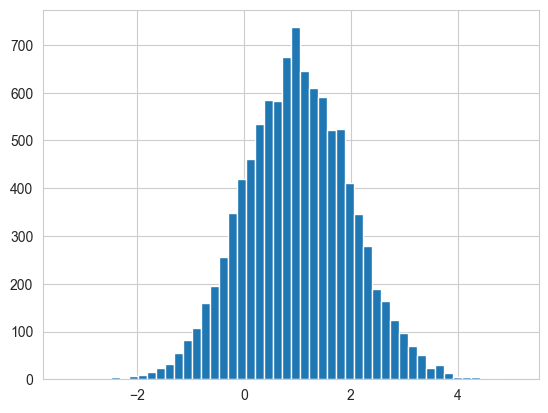

In [4]:
plt.hist(samples_p.numpy(), bins=50)
plt.show()

## 重要性采样
目标分布 $p(x)$ 可能采样困难或者效率低下，从一个更容易采样的 $q(x)$ 采样并加权求和。
数学推导：
$$
E_{x \thicksim p}[f(x)] = E_{x \thicksim q} \left[ \frac{p(x)}{q(x)}f(x) \right] ≈ \frac{1}{N}  \sum_{i}^{N} \frac{p(x_i)}{q(x_i)} f(x_i)
$$
* 变体：加权重要性采样 (Weighted Importance Sampling):  
标准重要性采样是无偏的，但方差可能很大。加权重要性采样通过归一化权重来减少方差，虽然会引入微小偏差，但通常能获得更好的均方误差。

$$J_{approx\hspace{0.2em}weighted} = \frac{\sum_{i=1}^{N} \rho_i  f(x_i)}{ \sum_{i=1}^{N} \rho_i}, where \rho_i = \frac{p(x_i)}{q(x_i)}$$


In [5]:
# --- 方法 2: 重要性采样 (从 q 采样) ---
# 选择提议分布 q。这里我们选一个更宽的平台分布，比如 Uniform(-2, 4)均匀分布
# 这是一个糟糕的选择，只是为了演示IS如何处理糟糕的q。
q = dist.Uniform(-2.0, 4.0)
samples_q = q.sample((N,))  # 从 q 采样

# 计算 f(x) = x^2
f_x = samples_q.pow(2)

# 计算重要性权重 p(x)/q(x)
# p.log_prob(samples_q).exp() 计算 p(x) 的概率密度
# q.log_prob(samples_q).exp() 计算 q(x) 的概率密度
rho = p.log_prob(samples_q).exp() / q.log_prob(samples_q).exp()

# 标准重要性采样
is_estimate = (rho * f_x).mean()
is_std = (rho * f_x).std() / torch.sqrt(torch.tensor(N))

# 加权重要性采样
weighted_is_estimate = (rho * f_x).sum() / rho.sum()

print(f"\n重要性采样估计 (标准): {is_estimate:.4f} ± {is_std:.4f}")    # 无偏
print(f"重要性采样估计 (加权): {weighted_is_estimate:.4f}")            # 有偏
print(f"标准IS与真实值的误差: {abs(is_estimate - true_value):.4f}")
print(f"加权IS与真实值的误差: {abs(weighted_is_estimate - true_value):.4f}")

# 注意：这个例子中因为q选的很差，IS的表现可能不如标准MC。
# 一个好的q（例如N(1, 2)）会显著优于标准MC。


重要性采样估计 (标准): 1.9820 ± 0.0204
重要性采样估计 (加权): 1.9855
标准IS与真实值的误差: 0.0180
加权IS与真实值的误差: 0.0145


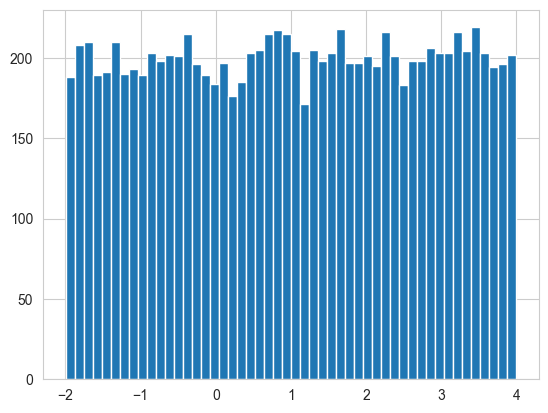

In [6]:
plt.hist(samples_q.numpy(), bins=50)
plt.show()

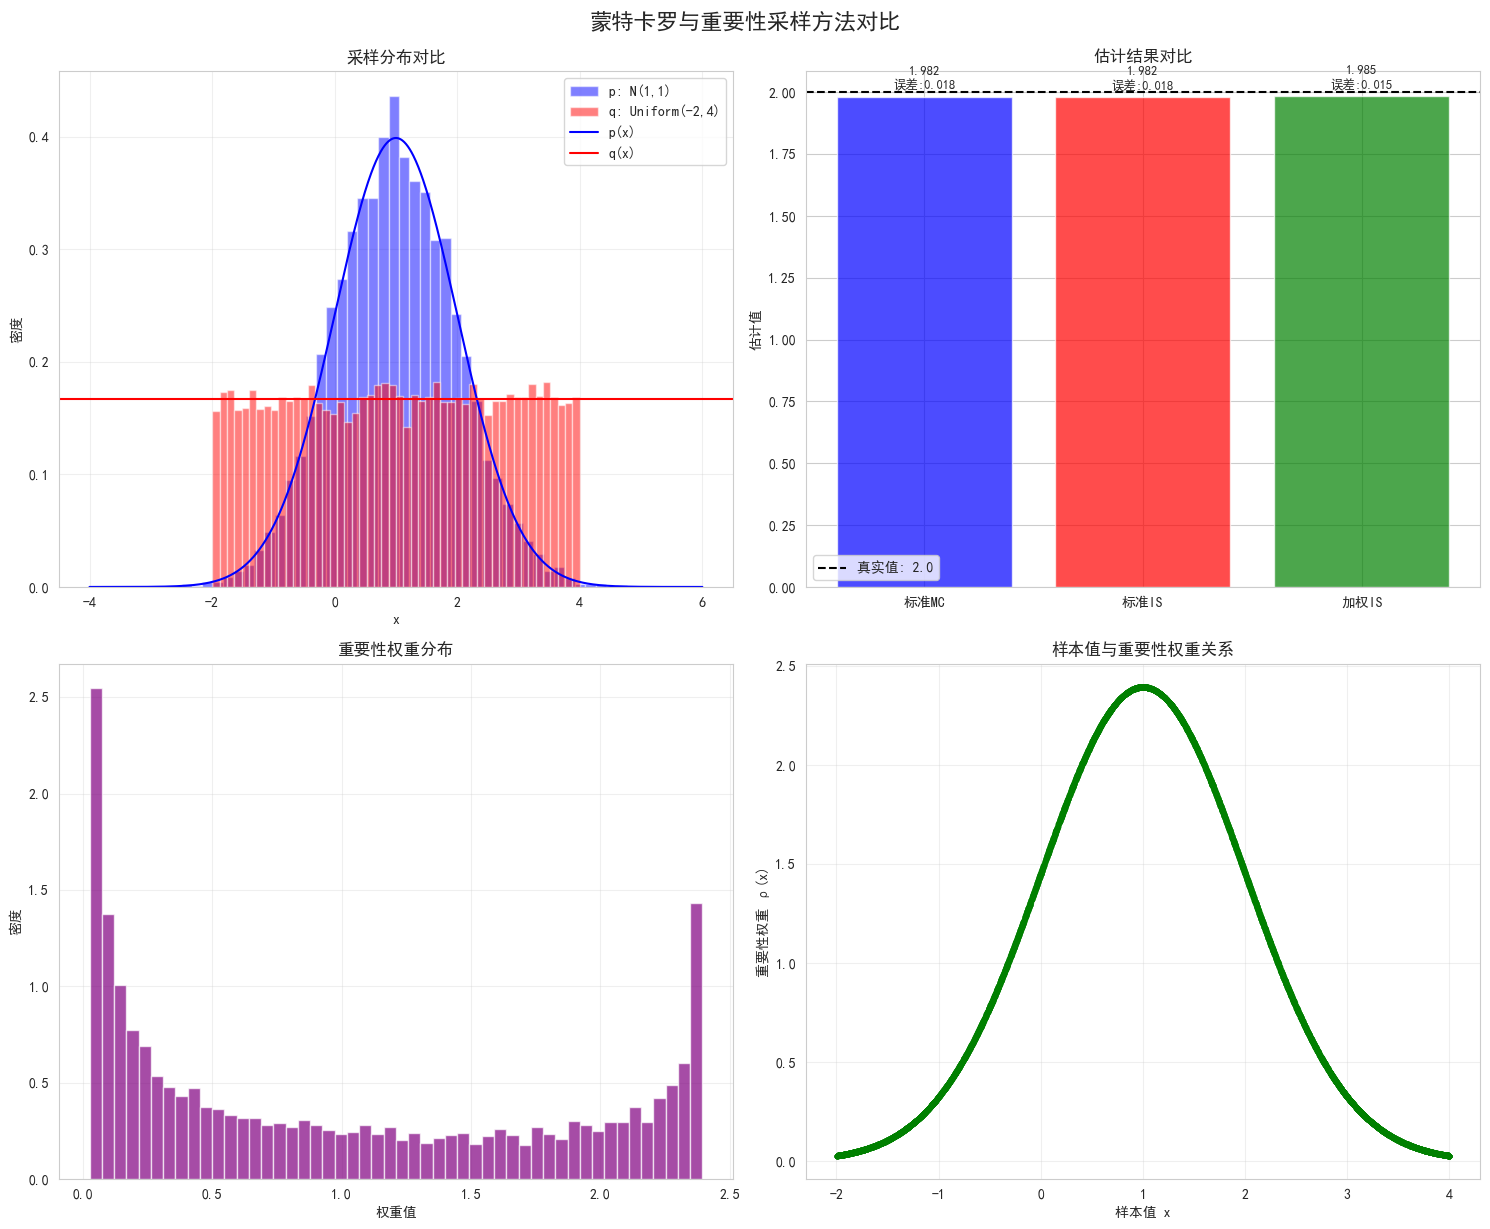

In [8]:
# 可视化
import matplotlib.font_manager as fm
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans'] 
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 采样分布对比
axes[0, 0].hist(samples_p.numpy(), bins=50, density=True, alpha=0.5, label='p: N(1,1)', color='blue')
axes[0, 0].hist(samples_q.numpy(), bins=50, density=True, alpha=0.5, label='q: Uniform(-2,4)', color='red')
x_range = np.linspace(-4, 6, 1000)
axes[0, 0].plot(x_range, np.exp(p.log_prob(torch.tensor(x_range)).numpy()), 'b-', label='p(x)')
axes[0, 0].axhline(y=1/6, xmin=-2, xmax=4, color='r', linestyle='-', label='q(x)')
axes[0, 0].set_title('采样分布对比')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('密度')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 估计结果对比
methods = ['标准MC', '标准IS', '加权IS']
estimates = [mc_estimate.item(), is_estimate.item(), weighted_is_estimate.item()]
errors = [abs(mc_estimate - true_value).item(), 
          abs(is_estimate - true_value).item(), 
          abs(weighted_is_estimate - true_value).item()]
colors = ['blue', 'red', 'green']

bars = axes[0, 1].bar(methods, estimates, color=colors, alpha=0.7)
axes[0, 1].axhline(y=true_value, color='black', linestyle='--', label=f'真实值: {true_value}')
axes[0, 1].set_title('估计结果对比')
axes[0, 1].set_ylabel('估计值')
axes[0, 1].legend()

# 在柱状图上添加数值标签
for bar, estimate, error in zip(bars, estimates, errors):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{estimate:.3f}\n误差:{error:.3f}', 
                    ha='center', va='bottom', fontsize=9)

# 3. 重要性权重分布
axes[1, 0].hist(rho.numpy(), bins=50, density=True, alpha=0.7, color='purple')
axes[1, 0].set_title('重要性权重分布')
axes[1, 0].set_xlabel('权重值')
axes[1, 0].set_ylabel('密度')
axes[1, 0].grid(True, alpha=0.3)

# 4. 权重与样本关系散点图
axes[1, 1].scatter(samples_q.numpy(), rho.numpy(), alpha=0.5, color='green', s=10)
axes[1, 1].set_title('样本值与重要性权重关系')
axes[1, 1].set_xlabel('样本值 x')
axes[1, 1].set_ylabel('重要性权重 ρ(x)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('蒙特卡罗与重要性采样方法对比', fontsize=16, y=1.02)
plt.show()